In [1]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='sans-serif')

from tqdm import tqdm

import torch
import torch.distributions as dist
import h5py

from geobed import BED_discrete
import geobed.fwd_collection.raytracer as raytracer
from geobed.guides import GMM_guide, MDN_guide, FullyConnected


In [3]:
filename_core = 'marmousi_vp_centersection'
filename = f"data/{filename_core}.npz"

with np.load(filename, allow_pickle=True) as marmousi_centersection:    
    x = marmousi_centersection['x']
    z = marmousi_centersection['z']
    marmousi_vp = marmousi_centersection['data']
    
# area of interest
e_x_min, e_x_max = min(x), max(x)
e_z_min, e_z_max = min(z), max(z)

dx, dz = x[1] - x[0], z[1] - z[0]

print(e_x_min, e_x_max)

3000.3185954411765 16500.503183088236


In [4]:
def construct_covmat(theta, ratio, scaling): 
    theta = -np.radians(theta)
    ratio = ratio
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    S = scaling * np.diag([ratio, 1])
    L = S**2
    return torch.tensor(R@L@R.T, dtype=dtype)

n_prior = int(2e7)
n_prior_plot = int(1e4)

# using float 32 for eveything to keep storage and loading times down
dtype, bytes = torch.float32, 4

mu1=torch.tensor([9.37, 1.91])*1e3
mu2=torch.tensor([10.1, 2.0])*1e3
mu3=torch.tensor([10.85, 2.01])*1e3
mu_list = [mu1, mu2, mu3]

cov1 = construct_covmat(10,  4, 0.12*1e3)
cov2 = construct_covmat(15,  6, 0.1*1e3)
cov3 = construct_covmat(5, 10, 0.08*1e3)
cov_list = [cov1, cov2, cov3]

mix = dist.Categorical(torch.tensor([0.3, 0.3, 0.3]))
comp = dist.MultivariateNormal(torch.stack(mu_list,axis=0),
                               covariance_matrix=torch.stack(cov_list, axis=0))

prior_dist = dist.MixtureSameFamily(mix, comp)

In [5]:
prior_samples = prior_dist.sample( (n_prior,) )

print('dimensions: (n_prior, model_dim) n_prior is more or less the batchsize')
print(prior_samples.shape, '\n')

n_designs = int(200)

print(e_x_min, e_x_max )
print(e_z_min, e_z_max )

designs = torch.ones((n_designs, 2))
designs[: ,0] = torch.linspace(3.1, 16.4, n_designs)*1e3
designs[: ,1] = 0.51 * torch.ones_like(designs[: ,0])*1e3

print('dimensions: (n_design, design_dim)')
print(designs.shape, '\n')

dimensions: (n_prior, model_dim) n_prior is more or less the batchsize
torch.Size([20000000, 2]) 

3000.3185954411765 16500.503183088236
499.77842857142855 2600.0972746428574
dimensions: (n_design, design_dim)
torch.Size([200, 2]) 



In [6]:
design_dim = 4

In [7]:
import os
import pickle

def load_data(filename):
    if os.path.isfile(filename):
        print(f'Loading optimal design from {filename}')
        with open(filename, 'rb') as f:
            out = pickle.load(f)
        return out
    else:
        print(f'File {filename} does not exist. Calculating optimal design.')

In [8]:
data_dict = {}
info_dict = {}

In [9]:
method = 'nmc_reuse'

out = load_data(f'data/srcloc_bed_{method}.pkl')
data_dict[method] = out[0]
info_dict[method] = out[1]
 
out = load_data(f'data/srcloc_noise_bed_{method}.pkl')
data_dict[method+'_noise'] = out[0]
info_dict[method+'_noise'] = out[1]

Loading optimal design from data/srcloc_bed_nmc_reuse.pkl
File data/srcloc_noise_bed_nmc_reuse.pkl does not exist. Calculating optimal design.


TypeError: 'NoneType' object is not subscriptable

In [ ]:
method = 'dn'

out = load_data(f'data/srcloc_bed_{method}.pkl')
data_dict[method] = out[0]
info_dict[method] = out[1]
 
out = load_data(f'data/srcloc_noise_bed_{method}.pkl')
data_dict[method+'_noise'] = out[0]
info_dict[method+'_noise'] = out[1]

Loading optimal design from data/srcloc_bed_dn.pkl
Loading optimal design from data/srcloc_noise_bed_dn.pkl


In [ ]:
method = 'variational_marginal'
filename = f'data/srcloc_bed_{method}.pkl'

unpickler = pickle.Unpickler(open(filename, 'rb'))

unpickler.find_class()

TypeError: __import__() argument 1 must be str, not type

In [ ]:
method = 'variational_marginal'

out = load_data(f'data/srcloc_bed_{method}.pkl')
data_dict[method] = out[0]
info_dict[method] = out[1]
 
out = load_data(f'data/srcloc_noise_bed_{method}.pkl')
data_dict[method+'_noise'] = out[0]
info_dict[method+'_noise'] = out[1]


Loading optimal design from data/srcloc_bed_variational_marginal.pkl


ModuleNotFoundError: No module named 'guides'

In [ ]:
method = 'variational_posterior'

out = load_data(f'data/srcloc_bed_{method}.pkl')
data_dict[method] = out[0]
info_dict[method] = out[1]
 
out = load_data(f'data/srcloc_noise_bed_{method}.pkl')
data_dict[method+'_noise'] = out[0]
info_dict[method+'_noise'] = out[1]

Loading optimal design from data/srcloc_bed_variational_posterior.pkl


ModuleNotFoundError: No module named 'guides'

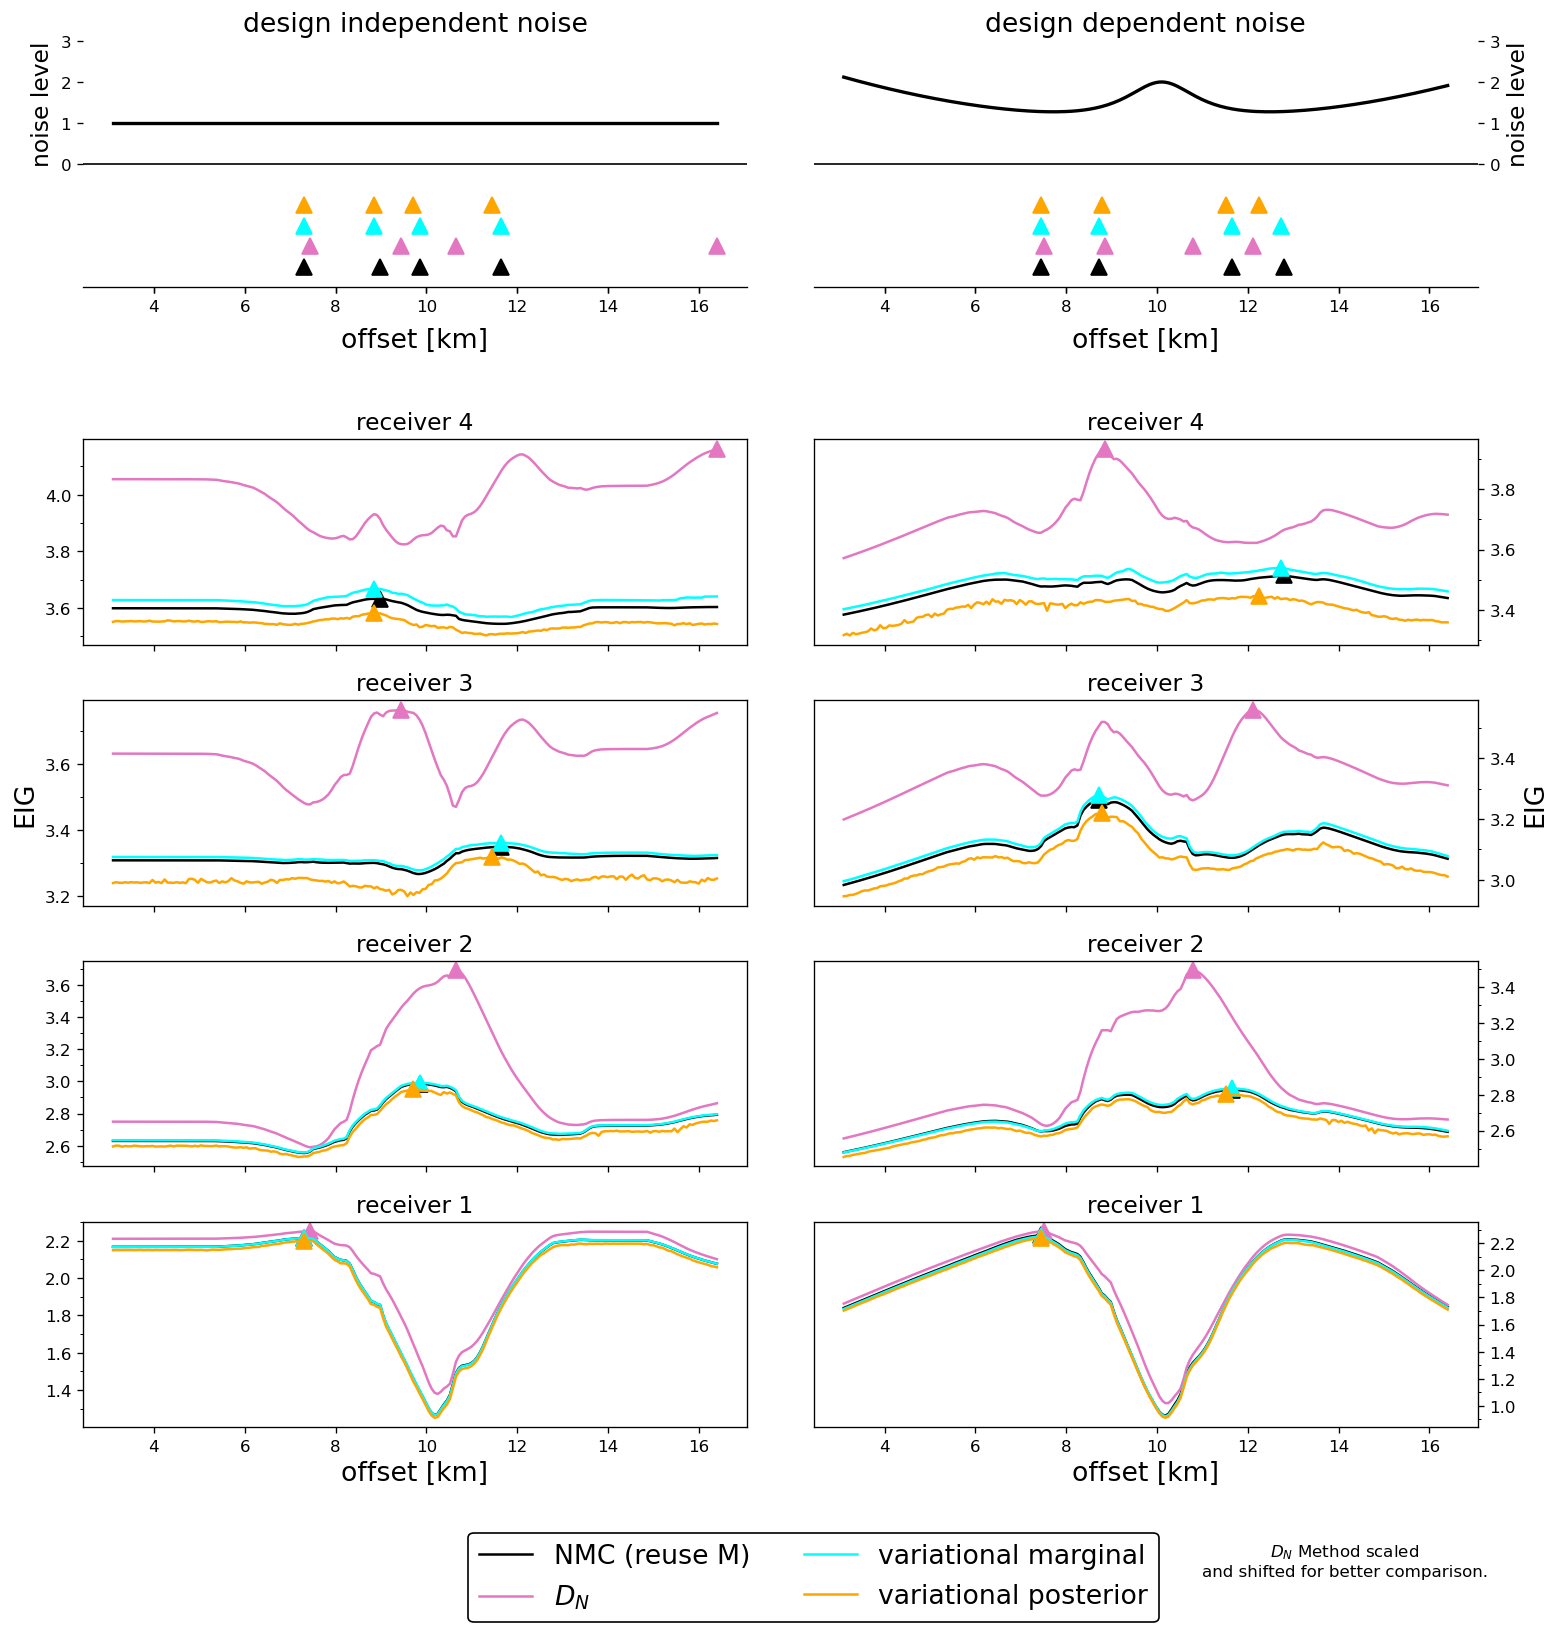

In [ ]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(15, 3*4+3), dpi=120)
ax_dict = fig.subplot_mosaic(
    [['f1', 'f2'],
     ['x' , 'x' ],
     # ['e1', 'e2'],
     ['d1', 'd2'],
     ['c1', 'c2'],
     ['b1', 'b2'],
     ['a1', 'a2'], 
    ], sharex=True, empty_sentinel='x', gridspec_kw={'hspace': 0.3, 'wspace': 0.1, 'height_ratios':[1.2, 0.2, 1, 1, 1, 1]},)


offsets = designs[: ,0]/1e3

ax_names = ['a', 'b', 'c', 'd']

gaussian_offsets = [0.0, 0.0, 0.55, 0.75]
gaussian_scalings = [1.0, 1.0, 1.0, 1.0]

methods = ['nmc_reuse', 'dn', 'variational_marginal', 'variational_posterior']

colour_dict = {'nmc': 'black', 'nmc_reuse': 'black', 'dn': 'tab:pink', 'variational_marginal': 'cyan', 'variational_posterior': 'orange'}
label_dict = {'nmc': 'NMC', 'nmc_reuse': 'NMC (reuse M)', 'dn': r'$D_N$', 'variational_marginal': 'variational marginal', 'variational_posterior': 'variational posterior'}

for i in range(1, 5):
    for method in methods:
        
        if method != 'dn':
            ax_dict[ax_names[i-1]+'1'].plot(offsets, info_dict[method][i]['eig'],
                                        color=colour_dict[method], label=label_dict[method])

            ax_dict[ax_names[i-1]+'2'].plot(offsets, info_dict[method+'_noise'][i]['eig'],
                                        color=colour_dict[method], label=label_dict[method])

            max_i = np.argmax(info_dict[method][i]['eig'])
            ax_dict[f'{ax_names[i-1]}1'].plot(offsets[[max_i]],
                                              info_dict[method][i]['eig'][[max_i]],
                                              marker='^', color=colour_dict[method], markersize=10, linestyle="None")
            
            max_i = np.argmax(info_dict[method+'_noise'][i]['eig'])
            ax_dict[f'{ax_names[i-1]}2'].plot(offsets[[max_i]],
                                              info_dict[method+'_noise'][i]['eig'][[max_i]],
                                              marker='^', color=colour_dict[method], markersize=10, linestyle="None")
        else:
            
            dn_eig = (torch.tensor(info_dict['dn'][i]['eig']) * gaussian_scalings[i-1]) - gaussian_offsets[i-1]
            
            dn_noise_eig = (torch.tensor(info_dict['dn_noise'][i]['eig']) * gaussian_scalings[i-1]) - gaussian_offsets[i-1]
            
            ax_dict[ax_names[i-1]+'1'].plot(offsets, dn_eig,
                                color=colour_dict['dn'], label=label_dict['dn'])
        
            ax_dict[ax_names[i-1]+'2'].plot(offsets, (torch.tensor(info_dict['dn'+'_noise'][i]['eig']) * gaussian_scalings[i-1]) - gaussian_offsets[i-1],
                                color=colour_dict['dn'], label=label_dict['dn'])
            
            max_i = np.argmax(dn_eig)
            ax_dict[f'{ax_names[i-1]}1'].plot(offsets[[max_i]],
                                              dn_eig[[max_i]],
                                              marker='^', color=colour_dict[method], markersize=10, linestyle="None")
            
            max_i = np.argmax(dn_noise_eig)
            ax_dict[f'{ax_names[i-1]}2'].plot(offsets[[max_i]],
                                              dn_noise_eig[[max_i]],
                                              marker='^', color=colour_dict[method], markersize=10, linestyle="None")
            
            
    ax_dict[ax_names[i-1]+'1'].yaxis.set_major_locator(MultipleLocator(0.2))
    ax_dict[ax_names[i-1]+'1'].yaxis.set_minor_locator(MultipleLocator(0.1))

    ax_dict[ax_names[i-1]+'2'].yaxis.set_major_locator(MultipleLocator(0.2))
    ax_dict[ax_names[i-1]+'2'].yaxis.set_minor_locator(MultipleLocator(0.1))
    
    ax_dict[ax_names[i-1]+'1'].set_title(f'receiver {i}', size=14)
    ax_dict[ax_names[i-1]+'2'].set_title(f'receiver {i}', size=14)

    ax_dict[f'{ax_names[i-1]}2'].yaxis.set_label_position("right")
    ax_dict[f'{ax_names[i-1]}2'].yaxis.tick_right()
    
ax_dict['a'+'1'].set_xlabel(r'offset [m]',  fontsize=18)
ax_dict['c'+'1'].set_ylabel(r'EIG', fontsize=16)

for m in methods:
    
    optimal_design = np.array([offsets[int(d)] for d in data_dict[m][:4]])
    
    ax_dict['f1'].plot(
    optimal_design, np.zeros(optimal_design[:4].shape[0]) - 2.5 + 0.5*methods.index(m),
    marker='^', color=colour_dict[m], markersize=10, linestyle="None")
    
    optimal_design_noise = np.array([offsets[int(d)] for d in data_dict[m+'_noise'][:4]])
    
    ax_dict['f2'].plot(
    optimal_design_noise, np.zeros(optimal_design_noise[:4].shape[0]) - 2.5 + 0.5*methods.index(m),
    marker='^', color=colour_dict[m], markersize=10, linestyle="None") 

for spin in ['top', 'right', 'left', 'bottom']:
    ax_dict['f1'].spines[spin].set_visible(False)
    ax_dict['f2'].spines[spin].set_visible(False)

x = offsets
    
def f(x):
    return x

ax_dict['f1'].set_ylim((-3, 3))

ax_dict['f1'].plot(x, 0*x + 1, linewidth=2, color='k', zorder=0, label='SNR')

ax_dict['f1'].set_yticks([0, 1, 2, 3])
ax_dict['f1'].axhline(0.0, color='k', linewidth=1)
ax_dict['f1'].secondary_xaxis('bottom', functions=(f, f))
ax_dict['f1'].set_xlabel(r'offset [km]', fontsize=16, labelpad=20)
ax_dict['f1'].set_title(r'design independent noise', fontsize=16)
ax_dict['f1'].set_ylabel('noise level', loc="top", fontsize=14)
    
ax_dict['f2'].set_ylim((-3, 3))
ax_dict['f2'].plot(x, 1 + 0.01 * (( 1.5 * (x - 10.1) )**2 + (100.5/(1+(x - 10.1)**2) ) ), linewidth=2, color='k', zorder=100, label='SNR')

ax_dict['f2'].set_yticks([0, 1, 2, 3])
ax_dict['f2'].axhline(0.0, color='k', linewidth=1)

ax_dict['f2'].secondary_xaxis('bottom', functions=(f, f))
ax_dict['f2'].set_xlabel(r'offset [km]', fontsize=16, labelpad=20)
ax_dict['f2'].set_title(r'design dependent noise', fontsize=16)
ax_dict['f2'].yaxis.set_label_position("right")
ax_dict['f2'].yaxis.tick_right()    
ax_dict['f2'].set_ylabel('noise level', loc="top", fontsize=14)

ax_dict['a1'].set_xlabel(r'offset [km]',  fontsize=16)
ax_dict['a2'].set_xlabel(r'offset [km]',  fontsize=16)

ax_dict['c1'].set_ylabel(r'EIG', fontsize=16)
ax_dict['c2'].set_ylabel(r'EIG', fontsize=16)

leg = ax_dict['a2'].legend(loc='upper center', bbox_to_anchor=(0.0, -0.45),
                           fontsize=16, fancybox=True, facecolor='white', framealpha=1, ncol=2)
leg.get_frame().set_edgecolor('k')

ax_dict['a2'].text(0.80, -0.65,'$D_N$ Method scaled\nand shifted for better comparison.', transform=ax_dict['a2'].transAxes,
                   fontsize=10, verticalalignment='center', horizontalalignment='center')

# fig.suptitle('Optimal Designs', fontsize=16)


fig.savefig(f'figures/srcloc_noise_comparison.pdf', bbox_inches='tight', dpi=150)
fig.savefig(f'figures/srcloc_noise_comparison.png', bbox_inches='tight', dpi=150)

plt.show()

KeyError: 'variational_marginal'

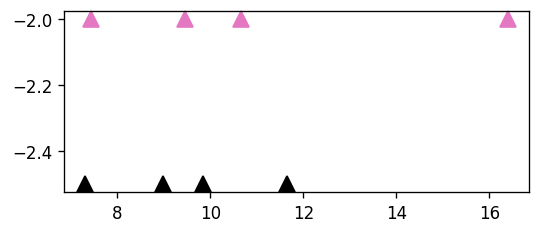

In [ ]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(5, 2), dpi=120)
ax_dict = fig.subplot_mosaic(
    [['f1'],

    ], sharex=True)


offsets = designs[: ,0]/1e3

ax_names = ['a', 'b', 'c', 'd']

gaussian_offsets = [0.0, 0.0, 0.55, 0.75]
gaussian_scalings = [1.0, 1.0, 1.0, 1.0]

methods = ['nmc_reuse', 'dn', 'variational_marginal', 'variational_posterior']

colour_dict = {'nmc': 'black', 'nmc_reuse': 'black', 'dn': 'tab:pink', 'variational_marginal': 'cyan', 'variational_posterior': 'orange'}
label_dict = {'nmc': 'NMC', 'nmc_reuse': 'NMC (reuse M)', 'dn': r'$D_N$', 'variational_marginal': 'variational marginal', 'variational_posterior': 'variational posterior'}


for m in methods:
    
    optimal_design = np.array([offsets[int(d)] for d in data_dict[m][:4]])
    
    ax_dict['f1'].plot(
    optimal_design, np.zeros(optimal_design[:4].shape[0]) - 2.5 + 0.5*methods.index(m),
    marker='^', color=colour_dict[m], markersize=10, linestyle="None", label=label_dict[m], clip_on=False)
    
    optimal_design_noise = np.array([offsets[int(d)] for d in data_dict[m+'_noise'][:4]])
    
    # ax_dict['f2'].plot(
    # optimal_design_noise, np.zeros(optimal_design_noise[:4].shape[0]) - 2.5 + 0.5*methods.index(m),
    # marker='^', color=colour_dict[m], markersize=10, linestyle="None") 

for spin in ['top', 'right', 'left', 'bottom']:
    ax_dict['f1'].spines[spin].set_visible(False)
    # ax_dict['f2'].spines[spin].set_visible(False)

x = offsets
    
def f(x):
    return x

ax_dict['f1'].set_ylim((-3, 3))

ax_dict['f1'].plot(x, 0*x + 1, linewidth=2, color='k', zorder=0)

ax_dict['f1'].set_yticks([0, 1, 2, 3])
ax_dict['f1'].axhline(0.0, color='k', linewidth=1)
ax_dict['f1'].secondary_xaxis('bottom', functions=(f, f))
ax_dict['f1'].set_xlabel(r'offset [km]', fontsize=16, labelpad=20)
ax_dict['f1'].set_title(r'design independent noise', fontsize=16)
ax_dict['f1'].set_ylabel('noise level', loc="top", fontsize=14)
    
# ax_dict['f2'].set_ylim((-3, 3))
# ax_dict['f2'].plot(x, 1 + 0.01 * (( 1.5 * (x - 10.1) )**2 + (100.5/(1+(x - 10.1)**2) ) ), linewidth=2, color='k', zorder=100, label='SNR')

# ax_dict['f2'].set_yticks([0, 1, 2, 3])
# ax_dict['f2'].axhline(0.0, color='k', linewidth=1)

# ax_dict['f2'].secondary_xaxis('bottom', functions=(f, f))
# ax_dict['f2'].set_xlabel(r'offset [km]', fontsize=16, labelpad=20)
# ax_dict['f2'].set_title(r'design dependent noise', fontsize=16)
# ax_dict['f2'].yaxis.set_label_position("right")
# ax_dict['f2'].yaxis.tick_right()    
# ax_dict['f2'].set_ylabel('noise level', loc="top", fontsize=14)


ax_dict['f1'].set_xlim((designs[0 ,0]/1e3,designs[-1 ,0]/1e3))

ax_dict['f1'].vlines(ax_dict['f1'].get_xlim()[0],
                     ymin=0, ymax=3,
                     clip_on=False, color='k', linewidth=1)

leg = ax_dict['f1'].legend(loc='upper center',
                           bbox_to_anchor=(0.5, -0.40),
                           fontsize=12, fancybox=True, facecolor='white', framealpha=1, ncol=2)
leg.get_frame().set_edgecolor('k')


# fig.suptitle('Optimal Designs', fontsize=16)


fig.savefig(f'figures/srcloc_noise_comparison_result.pdf', bbox_inches='tight', dpi=150)
fig.savefig(f'figures/srcloc_noise_comparison_result.png', bbox_inches='tight', dpi=150)

plt.show()

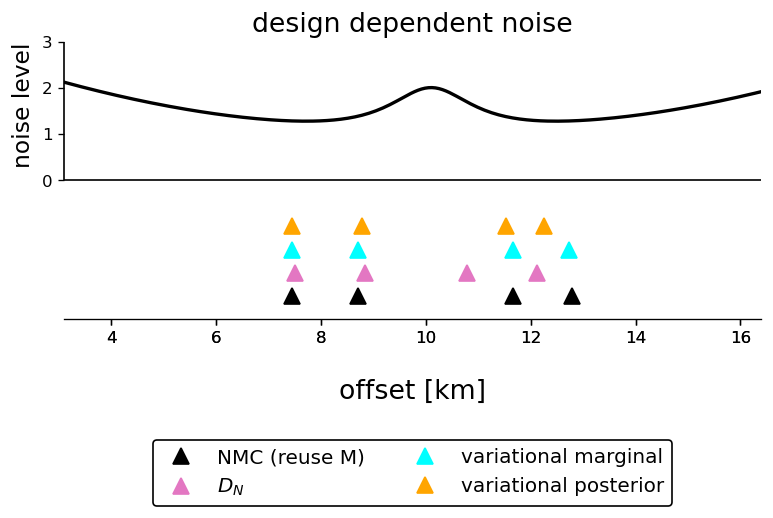

In [ ]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(5, 2), dpi=120)
ax_dict = fig.subplot_mosaic(
    [['f2'],

    ], sharex=True)


offsets = designs[: ,0]/1e3

ax_names = ['a', 'b', 'c', 'd']

gaussian_offsets = [0.0, 0.0, 0.55, 0.75]
gaussian_scalings = [1.0, 1.0, 1.0, 1.0]

methods = ['nmc_reuse', 'dn', 'variational_marginal', 'variational_posterior']

colour_dict = {'nmc': 'black', 'nmc_reuse': 'black', 'dn': 'tab:pink', 'variational_marginal': 'cyan', 'variational_posterior': 'orange'}
label_dict = {'nmc': 'NMC', 'nmc_reuse': 'NMC (reuse M)', 'dn': r'$D_N$', 'variational_marginal': 'variational marginal', 'variational_posterior': 'variational posterior'}

for m in methods:
    
    optimal_design_noise = np.array([offsets[int(d)] for d in data_dict[m+'_noise'][:4]])
    
    ax_dict['f2'].plot(
    optimal_design_noise, np.zeros(optimal_design_noise[:4].shape[0]) - 2.5 + 0.5*methods.index(m),
    marker='^', color=colour_dict[m], markersize=10, linestyle="None", label=label_dict[m], clip_on=False) 

for spin in ['top', 'right', 'left', 'bottom']:
    ax_dict['f2'].spines[spin].set_visible(False)

x = offsets
    
def f(x):
    return x
    
ax_dict['f2'].set_ylim((-3, 3))
ax_dict['f2'].plot(x, 1 + 0.01 * (( 1.5 * (x - 10.1) )**2 + (100.5/(1+(x - 10.1)**2) ) ), linewidth=2, color='k', zorder=100)

ax_dict['f2'].set_yticks([0, 1, 2, 3])
ax_dict['f2'].axhline(0.0, color='k', linewidth=1)

ax_dict['f2'].secondary_xaxis('bottom', functions=(f, f))
ax_dict['f2'].set_xlabel(r'offset [km]', fontsize=16, labelpad=20)
ax_dict['f2'].set_title(r'design dependent noise', fontsize=16)
# ax_dict['f2'].yaxis.set_label_position("right")
# ax_dict['f2'].yaxis.tick_right()    
ax_dict['f2'].set_ylabel('noise level', loc="top", fontsize=14)

ax_dict['f2'].set_xlim((designs[0 ,0]/1e3,designs[-1 ,0]/1e3))

ax_dict['f2'].vlines(ax_dict['f2'].get_xlim()[0],
                     ymin=0, ymax=3,
                     clip_on=False, color='k', linewidth=1)

leg = ax_dict['f2'].legend(loc='upper center',
                           bbox_to_anchor=(0.5, -0.40),
                           fontsize=12, fancybox=True, facecolor='white', framealpha=1, ncol=2)
leg.get_frame().set_edgecolor('k')


# fig.suptitle('Optimal Designs', fontsize=16)


fig.savefig(f'figures/srcloc_noise_comparison_result_noise.pdf', bbox_inches='tight', dpi=150)
fig.savefig(f'figures/srcloc_noise_comparison_result_noise.png', bbox_inches='tight', dpi=150)

plt.show()